In [1]:
import os 
import pathlib
import pickle as pkl
import cloudpickle 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, StandardScaler, RobustScaler
from sklearn.neural_network import MLPClassifier
pd.set_option('display.max_columns', None)
from bill_classification import *
import shap

In [3]:
shap.initjs()

In [4]:
model_path = '../out/models/MLP_fit.pkl'
split_data_path = '../data/preprocessed/split_data.pkl'
eval_folder = '../out/MLP_eval'
states_lobby = ["IA", "MA", "NE", "NJ", "RI", "WI"] 

#eval_MLP(model_path=model_path, split_data_path=split_data_path, eval_folder=eval_folder)

In [5]:
plot_path=os.path.join(eval_folder, "shap_plot.html")
shap_val_path=os.path.join(eval_folder, "shap_values.pkl")
with open(model_path, 'rb') as file:
    clf_pipeline_MLP  = pkl.load(file)
with open(split_data_path, 'rb') as file:
    X_train, X_test, y_train, y_test, y_classes, bill_ls = pkl.load(file)

MLP_best = clf_pipeline_MLP.named_steps.classifier.best_estimator_       #get best estimator from pipe
feature_names = clf_pipeline_MLP.named_steps.preprocessor.get_feature_names_out().tolist()

X_train_grouped = X_train.groupby("state") #create grouped objects 
X_test_grouped = X_test.groupby("state") #create grouped objects 

In [ ]:
#create loop: for state in states lobby    
X_tr_IA = clf_pipeline_MLP.named_steps.preprocessor.transform(X_train_grouped.get_group("RI"))
X_te_IA = clf_pipeline_MLP.named_steps.preprocessor.transform(X_test_grouped.get_group("RI"))

In [7]:
explainer_IA = shap.KernelExplainer(MLP_best.predict, X_tr_IA, feature_names = np.array(feature_names))
#get predictions on the subst: 
y_pred = MLP_best.predict(X_te_IA)

Using 4830 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [8]:
#explanation object:IA
shap_IA = explainer_IA(X_te_IA[0:100])

  0%|          | 0/100 [00:00<?, ?it/s]

: 

In [ ]:

#X_train_tr = clf_pipeline_MLP.named_steps.preprocessor.transform(X_train)#transform training data
#X_test_tr = clf_pipeline_MLP.named_steps.preprocessor.transform(X_test)  #transform test data


In [ ]:
#get feature names
#defined explainer object 
explainer_pred = shap.KernelExplainer(MLP_best.predict, X_train_tr, feature_names = np.array(feature_names))
#get predictions on the subst: 
y_pred = MLP_best.predict(X_test_tr)

In [ ]:
#explanation object
shap_expl = explainer_pred(X_test_ia)

  0%|          | 0/684 [00:00<?, ?it/s]

In [ ]:
#shap values
shap_values = explainer_pred.shap_values(X_test_tr)

  0%|          | 0/15 [00:00<?, ?it/s]

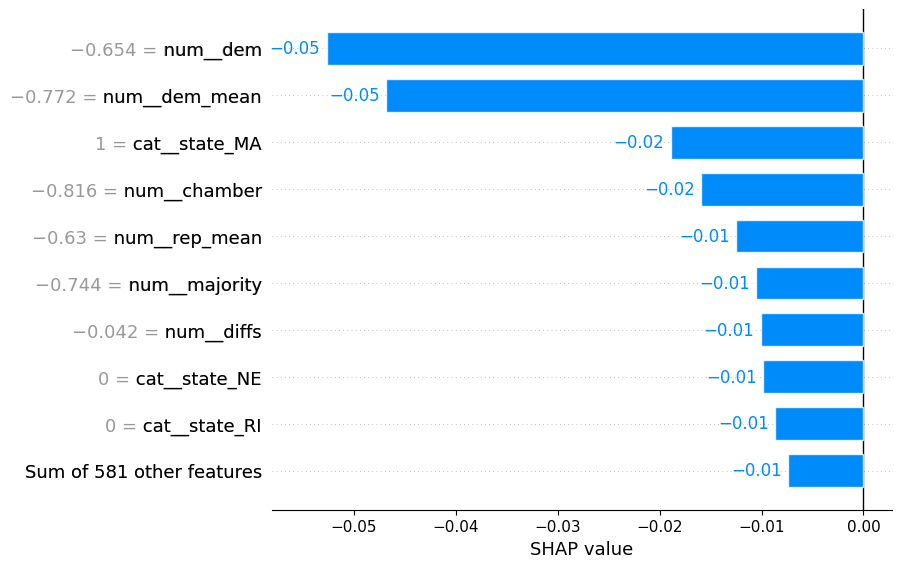

In [12]:
shap.plots.bar(shap_expl[1])

In [125]:
ind = 0 #index of target
print(f"true value: {y_test[ind][0]} predicted value: {y_pred[ind]}")

shap.force_plot(explainer_pred.expected_value, shap_values[ind,:] , 
                X_test_tr[ind,:],feature_names=feature_names)

true value: 1 predicted value: 1


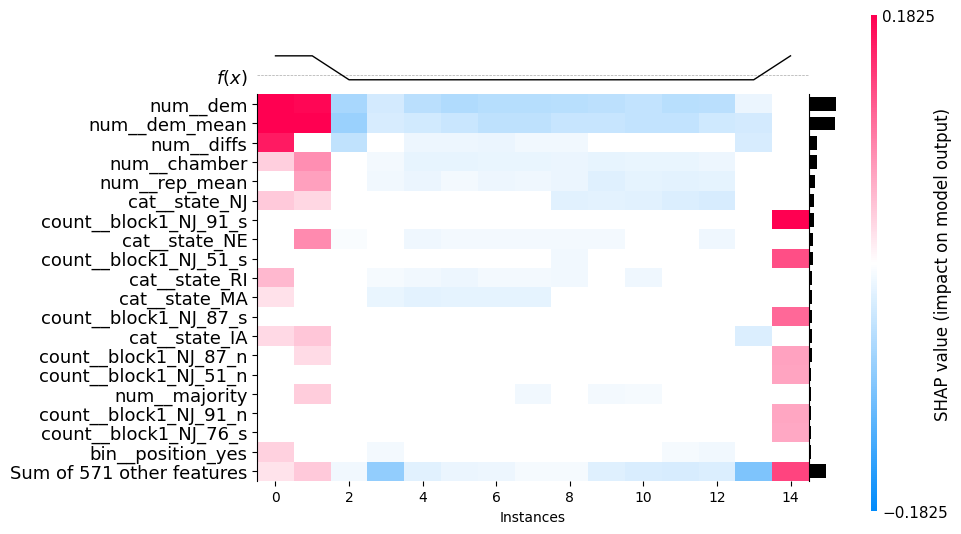

<Axes: xlabel='Instances'>

In [14]:
shap.plots.heatmap(shap_expl, max_display=20)

In [126]:
shap.force_plot(explainer_pred.expected_value, 
                shap_values, X_test_tr, feature_names = feature_names)

In [3]:
def shap_plot(model_path, split_data_path, plot_path, shap_val_path):
    """ 
    Extract shap values for a subset (100) of the data and plot it to out path
    """
    with open(model_path, 'rb') as file:
        clf_pipeline_MLP  = pkl.load(file)
    with open(split_data_path, 'rb') as file:
        X_train, X_test, y_train, y_test, y_classes, bill_ls = pkl.load(file)
 
    X_train_tr = clf_pipeline_MLP.named_steps.preprocessor.transform(X_train)#transform training data
    X_train_tr_s = shap.sample(X_train_tr, nsamples=100, random_state=37)    #subset train data
    X_test_tr = clf_pipeline_MLP.named_steps.preprocessor.transform(X_test)  #transform test data
    X_test_tr_s = shap.sample(X_test_tr, nsamples=15, random_state=37)       #subset test data
    MLP_best = clf_pipeline_MLP.named_steps.classifier.best_estimator_       #get best estimator from pipe
    explainer = shap.KernelExplainer(MLP_best.predict_proba, X_train_tr_s)     #define explainer 
    shap_values = explainer.shap_values(X_test_tr_s)

    with open(shap_val_path, 'wb') as file:
        cloudpickle.dump((shap_values, explainer, X_train_tr, X_test_tr, X_test_tr_s, MLP_best), file)

    return print("done shap vals ")

In [2]:
model_path='../out/models/MLP_fit.pkl'
split_data_path="../data/preprocessed/split_data.pkl"

with open(model_path, 'rb') as file:
    clf_pipeline_MLP  = pkl.load(file)
with open(split_data_path, 'rb') as file:
    X_train, X_test, y_train, y_test, y_classes, bill_ls = pkl.load(file)

In [10]:
##SHAP
#transform training data using preprocessor in pipeline & #sample a subset of data: 
X_train_tr = clf_pipeline_MLP.named_steps.preprocessor.transform(X_train)
#X_train_tr_s = shap.sample(X_train_tr, nsamples=100, random_state=37)
#transform test data & sample subset
X_test_tr = clf_pipeline_MLP.named_steps.preprocessor.transform(X_test)
X_test_tr_s = shap.sample(X_test_tr, nsamples=100, random_state=37)
#extract best estimator from pipeline
MLP_best = clf_pipeline_MLP.named_steps.classifier.best_estimator_
#define explainer 
explainer = shap.KernelExplainer(MLP_best.predict_proba, X_train_tr)

Using 36736 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:

shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test)